In [7]:
import pandas as pd
import numpy as np
from os.path import exists
from tqdm import tqdm
import matplotlib.pyplot as plt
# Variables that contains the file location
from files import *
from functions import get_genres
import datatable as dt
from collections import defaultdict

# Data
Load the Data

## Song informations

In [76]:
# genres
genres  = dt.fread(file_genres_2).to_pandas()
genres.set_index('id', inplace=True)
# song infos (artist, song, album name)
info  = dt.fread(file_info_2).to_pandas()
info.set_index('id', inplace=True)

In [77]:
# convert genres to a list
genres['genre']= genres.genre.apply(lambda x: get_genres(x))

In [78]:
genres.head(1)

,genre
id,
0009fFIM1eYThaPg,[pop]


In [5]:
info.head(1)

,artist,song,album_name
id,,,
0009fFIM1eYThaPg,Cheryl,Rain on Me,3 Words


## Lyrics based features

In [6]:
# lyrics based feature vectors
tf_idf  = dt.fread(file_tfidf_2).to_pandas()
tf_idf.set_index('id', inplace=True)

word2vec  = dt.fread(file_word2vec_2, header=True).to_pandas()
word2vec.set_index('id', inplace=True)

bert = dt.fread(file_bert_2,header=True).to_pandas()
bert.set_index('id', inplace=True)

## Audio features

### [Low-level] Essentia

In [7]:
essentia  = dt.fread(file_essentia).to_pandas()
essentia.set_index('id', inplace=True)
essentia.head(2)

,lowlevel.average_loudness,lowlevel.barkbands.mean_0,lowlevel.barkbands.mean_1,lowlevel.barkbands.mean_2,lowlevel.barkbands.mean_3,lowlevel.barkbands.mean_4,lowlevel.barkbands.mean_5,lowlevel.barkbands.mean_6,lowlevel.barkbands.mean_7,lowlevel.barkbands.mean_8,...,tonal.thpcp_30,tonal.thpcp_31,tonal.thpcp_32,tonal.thpcp_33,tonal.thpcp_34,tonal.thpcp_35,tonal.tuning_diatonic_strength,tonal.tuning_equal_tempered_deviation,tonal.tuning_frequency,tonal.tuning_nontempered_energy_ratio
id,,,,,,,,,,,,,,,,,,,,,
0009fFIM1eYThaPg,0.933530,0.003060,0.015665,0.004106,0.001265,0.001988,0.001152,0.000906,0.000356,0.001064,...,0.752843,0.544830,0.394721,0.372330,0.422420,0.855395,0.563373,0.226941,434.193115,0.944264
0010xmHR6UICBOYT,0.985564,0.009209,0.078349,0.004850,0.001458,0.000622,0.000331,0.001254,0.003589,0.000960,...,0.119888,0.325183,0.882466,0.917528,0.421067,0.563627,0.500238,0.263457,434.193115,0.981752


### [Mid-level] BLF: Block-Level features

In [8]:
# BLF: Block-Level features

blf_correlation  = dt.fread(file_blf_correlation).to_pandas()
blf_correlation.set_index('id', inplace=True)

blf_deltaspectral  = dt.fread(file_blf_deltaspectral).to_pandas()
blf_deltaspectral.set_index('id', inplace=True)

blf_spectral  = dt.fread(file_blf_spectral).to_pandas()
blf_spectral.set_index('id', inplace=True)

blf_spectralcontrast  = dt.fread(file_blf_spectralcontrast).to_pandas()
blf_spectralcontrast.set_index('id', inplace=True)

blf_vardeltaspectral  = dt.fread(file_blf_vardeltaspectral).to_pandas()
blf_vardeltaspectral.set_index('id', inplace=True)

blf_logfluc  = dt.fread(file_blf_logfluc)

# This is done because in the csv it has an extra column name, 
# so in case someone with the original dataset tries to run it, it fixes that error
# It looks weird, but it is because first i am loading the data into datatable and then pass it to dataframe
new_cols = ['id']
new_cols.extend(list(blf_logfluc.names[2:]))
new_cols = tuple(new_cols)
del blf_logfluc[:, -1]

blf_logfluc.names = new_cols
blf_logfluc = blf_logfluc.to_pandas()
blf_logfluc.set_index('id', inplace=True)

### [Mid-level] MFCC: Mel Frequency Cepstral Coefficients

In [9]:
mfcc_bow  = dt.fread(file_mfcc_bow).to_pandas()
mfcc_bow.set_index('id', inplace=True)

mfcc_stats  = dt.fread(file_mfcc_stats).to_pandas()
mfcc_stats.set_index('id', inplace=True)



## Video features

In [10]:
incp  = dt.fread(file_incp).to_pandas()
incp.set_index('id', inplace=True)

resnet  = dt.fread(file_resnet).to_pandas()
resnet.set_index('id', inplace=True)

vgg19  = dt.fread(file_vgg19).to_pandas()
vgg19.set_index('id', inplace=True)

# Genre Statistics

In [8]:
# Number of songs per genre

genre_frequencies = defaultdict(int)
all_genres = genres.genre
for song in all_genres:
    for genre in song:
        genre_frequencies[genre] += 1
dictionary_genres = pd.DataFrame(genre_frequencies, index=[0]).T
dictionary_genres.columns = ['Frequency']
# sort it
dictionary_genres.sort_values(by=['Frequency'], ascending=False, inplace=True)
original_dict_size = len(dictionary_genres)
dictionary_genres

,Frequency
rock,33912
pop,28841
alternative rock,17147
indie rock,11997
singer songwriter,10935
...,...
indie jazz,1
rap metalcore,1
atmospheric dnb,1
hungarian rock,1


In [12]:
print("Total of genres", original_dict_size)

Total of genres 1670


In [13]:
# Number of Genres with only one song
print("No of genres with only one song:",(dictionary_genres < 2).value_counts().values[0])

No of genres with only one song: 1363


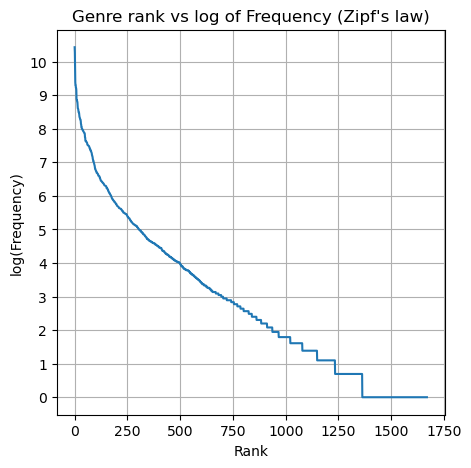

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(np.arange(len(dictionary_genres)), [np.log(f) for f in dictionary_genres['Frequency']])
ax.set_xlabel('Rank')
ax.set_ylabel('log(Frequency)')
ax.set_yticks(np.arange(11))
ax.set_title('Genre rank vs log of Frequency (Zipf\'s law)')
ax.grid(True)
plt.savefig('./plots/genre_rang_vs_freq.png',bbox_inches='tight')

dictionary size: 1670



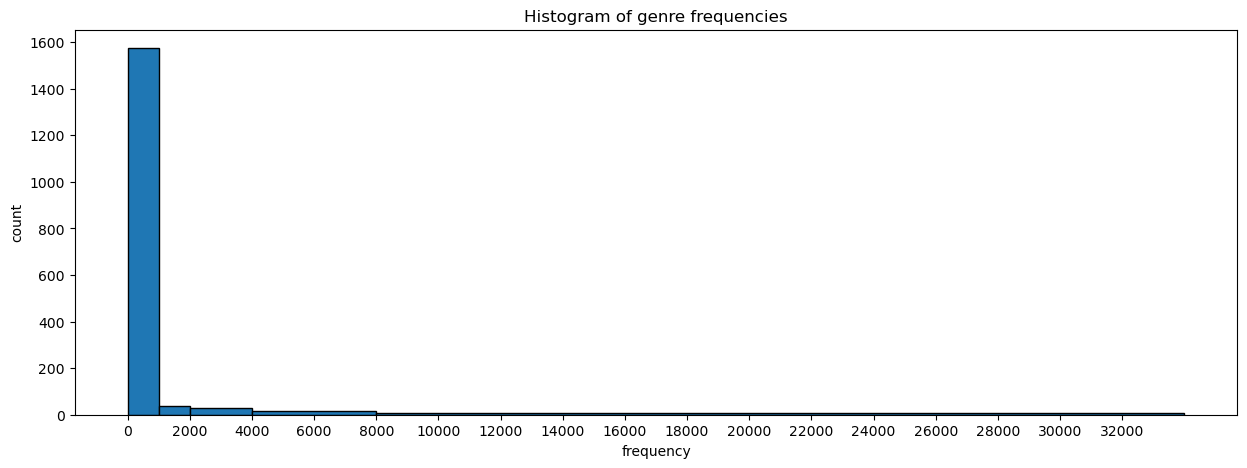

In [15]:
max_frequency_rounded =  round(dictionary_genres['Frequency'][0], -3)
bins = [0, 1000, 2000, 4000, 8000, max_frequency_rounded]
# statistics before cut off
print(f'dictionary size: {original_dict_size}\n')

fig, axs = plt.subplots(1, 1, figsize=(15, 5), sharey=True)
axs.hist(dictionary_genres['Frequency'], bins=bins,edgecolor='black', linewidth=1.0)
#axs.set_ylim(0, 100) 
axs.set_xticks(np.arange(0,max_frequency_rounded,2000))
axs.set_title('Histogram of genre frequencies')
axs.set_xlabel('frequency')
axs.set_ylabel('count')
axs.grid(False)
plt.savefig('./plots/histo_genre_freq.png',bbox_inches='tight')

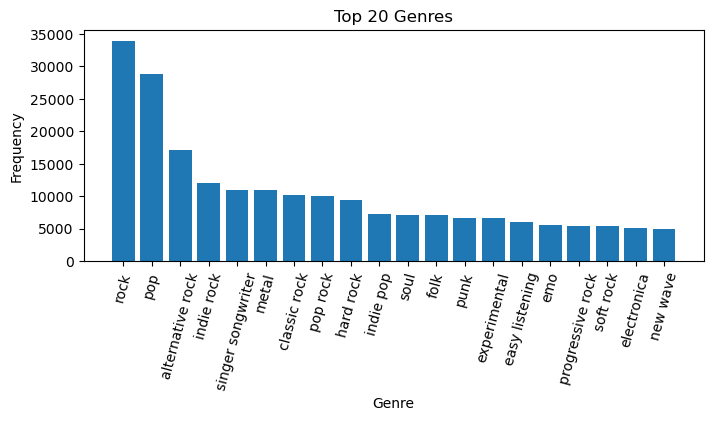

In [16]:
show_n = 20
fig, axs = plt.subplots(1, 1, figsize=(8, 3), sharey=True)
axs.bar(list(dictionary_genres.index)[:show_n], dictionary_genres['Frequency'][:show_n])
axs.set_title('Top 20 Genres')
axs.set_xlabel('Genre')
axs.set_ylabel('Frequency')
axs.tick_params(axis='x', labelrotation=75)
axs.grid(False)
plt.savefig('./plots/top20genres.png',bbox_inches='tight')

count    68641.000000
mean         7.176279
std          5.432006
min          1.000000
25%          3.000000
50%          6.000000
75%         10.000000
max         54.000000
Name: n_genres, dtype: float64


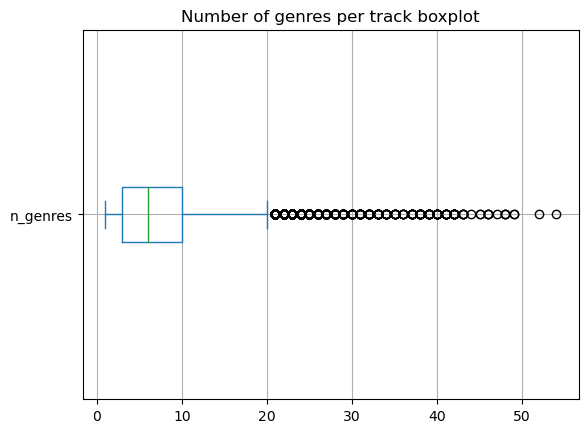

In [17]:
# count genres for each song
genres['n_genres']= genres.genre.apply(lambda x: len(x))
# get average number of genres
print(genres['n_genres'].describe())
genres['n_genres'].plot(kind='box', vert=False);
# plt.boxplot(genres['n_genres'],vert=False, sym="")
plt.grid(True)
plt.title("Number of genres per track boxplot")
plt.show()

That means that at least 50% of the tracks only have between 3 and 10 genres.
However, the track with more genres has up to 54 genres, and the tracks with less genres only have one genre

In [18]:
# average number of tracks that share one genre
dictionary_genres.Frequency.mean()

294.9622754491018

That means that in average 294 tracks share one genre.

In [19]:
# most common words in lyrics
common_words = tf_idf.sum().sort_values(ascending=False)

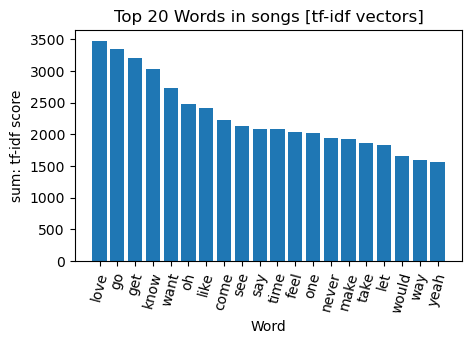

In [20]:
show_n = 20
fig, axs = plt.subplots(1, 1, figsize=(5, 3), sharey=True)
axs.bar(list(common_words.index)[:show_n], common_words[:show_n])
axs.set_title('Top 20 Words in songs [tf-idf vectors]')
axs.set_xlabel('Word')
axs.set_ylabel('sum: tf-idf score')
axs.tick_params(axis='x', labelrotation=75)
axs.grid(False)
plt.savefig('./plots/lyrics_top20words.png',bbox_inches='tight')

# Feature statistics

In [9]:
def get_song_by_genre(genre:str, data:pd.DataFrame):
    # return song_ids which the genre fit
    songs = []
    index = data.index.to_list()
    for i, s in enumerate(data.genre):
        if genre in s:
            songs.append(index[i])
    return songs

In [22]:
songs_gen1 = get_song_by_genre('metal', genres)
songs_gen2 = get_song_by_genre('soul', genres)

In [23]:
gen1 = essentia.loc[songs_gen1]
gen1.mean()

lowlevel.average_loudness                  0.954720
lowlevel.barkbands.mean_0                  0.000521
lowlevel.barkbands.mean_1                  0.009539
lowlevel.barkbands.mean_2                  0.005177
lowlevel.barkbands.mean_3                  0.002779
                                            ...    
tonal.thpcp_35                             0.741682
tonal.tuning_diatonic_strength             0.563986
tonal.tuning_equal_tempered_deviation      0.162690
tonal.tuning_frequency                   438.592018
tonal.tuning_nontempered_energy_ratio      0.830550
Length: 1034, dtype: float64

In [24]:
gen2 = essentia.loc[songs_gen2]
gen2.mean()

lowlevel.average_loudness                  0.923373
lowlevel.barkbands.mean_0                  0.000721
lowlevel.barkbands.mean_1                  0.009442
lowlevel.barkbands.mean_2                  0.003448
lowlevel.barkbands.mean_3                  0.001957
                                            ...    
tonal.thpcp_35                             0.705236
tonal.tuning_diatonic_strength             0.596303
tonal.tuning_equal_tempered_deviation      0.150675
tonal.tuning_frequency                   438.694964
tonal.tuning_nontempered_energy_ratio      0.816796
Length: 1034, dtype: float64

## Intersections on one Song

In [9]:
def getSongIdByQuery(artist, track):
    id_ = info[(info['artist'] == artist) & (info['song'] == track)]
    if len(id_) == 0: # If the data entered dont return any song
        return None
    return id_.index.values[0]

In [12]:
# Lyrics
top_cosine_tfidf  = dt.fread(f_top_cosine_tfidf, header=True).to_pandas()
top_cosine_tfidf.set_index('index', inplace=True)
top_cosine_word2vec  = dt.fread(f_top_cosine_word2vec, header=True).to_pandas()
top_cosine_word2vec.set_index('index', inplace=True)
top_cosine_bert  = dt.fread(f_top_cosine_bert, header=True).to_pandas()
top_cosine_bert.set_index('index', inplace=True)

In [13]:
# Audio
top_cosine_mfcc_bow  = dt.fread(f_top_cosine_mfcc_bow, header=True).to_pandas()
top_cosine_mfcc_bow.set_index('index', inplace=True)
top_cosine_mfcc_stats  = dt.fread(f_top_cosine_mfcc_stats, header=True).to_pandas()
top_cosine_mfcc_stats.set_index('index', inplace=True)
top_cosine_essentia  = dt.fread(f_top_cosine_essentia, header=True).to_pandas()
top_cosine_essentia.set_index('index', inplace=True)
top_cosine_blf_delta_spectral  = dt.fread(f_top_cosine_blf_delta_spectral, header=True).to_pandas()
top_cosine_blf_delta_spectral.set_index('index', inplace=True)
top_cosine_blf_correlation  = dt.fread(f_top_cosine_blf_correlation, header=True).to_pandas()
top_cosine_blf_correlation.set_index('index', inplace=True)
top_cosine_blf_logfluc  = dt.fread(f_top_cosine_blf_logfluc, header=True).to_pandas()
top_cosine_blf_logfluc.set_index('index', inplace=True)
top_cosine_blf_spectral  = dt.fread(f_top_cosine_blf_spectral, header=True).to_pandas()
top_cosine_blf_spectral.set_index('index', inplace=True)
top_cosine_blf_spectral_contrast  = dt.fread(f_top_cosine_blf_spectral_contrast, header=True).to_pandas()
top_cosine_blf_spectral_contrast.set_index('index', inplace=True)
top_cosine_blf_vardelta_spectral  = dt.fread(f_top_cosine_blf_vardelta_spectral, header=True).to_pandas()
top_cosine_blf_vardelta_spectral.set_index('index', inplace=True)

In [14]:
# Video
top_cosine_incp  = dt.fread(f_top_cosine_incp, header=True).to_pandas()
top_cosine_incp.set_index('index', inplace=True)
top_cosine_vgg19  = dt.fread(f_top_cosine_vgg19, header=True).to_pandas()
top_cosine_vgg19.set_index('index', inplace=True)
top_cosine_resnet  = dt.fread(f_top_cosine_resnet, header=True).to_pandas()
top_cosine_resnet.set_index('index', inplace=True)

In [19]:
# lets create a dict so we can loop over it
features = {
    'tfidf': top_cosine_tfidf,
    'word2vec': top_cosine_word2vec,
    'bert': top_cosine_bert,
    'mfcc_bow': top_cosine_mfcc_bow,
    'mfcc_stats': top_cosine_mfcc_stats,
    'essentia': top_cosine_essentia,
    'blf_delta_spectral': top_cosine_blf_delta_spectral,
    'blf_correlation': top_cosine_blf_correlation,
    'blf_logfluc': top_cosine_blf_logfluc,
    'blf_spectral': top_cosine_blf_spectral,
    'blf_spectral_contrast': top_cosine_blf_spectral_contrast,
    'blf_vardelta_spectral': top_cosine_blf_vardelta_spectral,
    'incp': top_cosine_incp,
    'vgg19': top_cosine_vgg19,
    'resnet': top_cosine_resnet
}

In [121]:
# get example song
song = getSongIdByQuery('The Chameleons', 'Nostalgia')
gen = genres.genre.loc[song]
k = 10

In [101]:
# get a top 10 list of each
topklist = {}
for name, feature in zip(features.keys(), features.values()):
    topklist[name] = feature.loc[song][:k]

In [103]:
# get the genres of each song
for name, songs in zip(topklist.keys(), topklist.values()):
    g = genres.genre.loc[songs.values]
    df = topklist[name].to_frame('songid')
    topklist[name] = df['genres'] = g

In [104]:
topklist['bert'].to_frame()

,genre
id,
tqc0WIiaCUyFpbU0,"[punk, rock, new wave, classic rock, alternati..."
dqBAZj6zw8CsY4Cf,"[rock, christian rock, hard rock, alternative ..."
m71LtJ9HiCiE4ewm,"[rock, punk, alternative rock, pop punk, skate..."
mTYfNBxLlX14TmTK,"[punk, rock, rockabilly, alternative rock, har..."
dfMDtC99XxwJBTho,[pop]
n01h8e2sZgEOTzkf,"[punk, rock, pop punk, alternative rock, grung..."
e2KFUcizqLnGSPcy,"[pop, rock, pop rock, folk, folk rock]"
mc489rIzGdg83sG4,"[indietronica, pop, new rave, indie pop, indie..."
bberSed6okySBCjE,"[rock, alternative rock, indie rock]"


In [132]:
#for name, songs in zip(topklist.keys(), topklist.values()):

matches = np.zeros(k)
for i, s in enumerate(topklist['bert']):
    matches[i] = len(set(gen) & set(s))
    
arr = matches > 0
arr

array([ True,  True,  True,  True, False,  True,  True, False,  True,
        True])

In [133]:
matches

array([5., 2., 2., 3., 0., 2., 1., 0., 2., 1.])